<a href="https://colab.research.google.com/github/EthanCherian/RMP-Wizard/blob/DNCHOW1-EDA/RMP_Logistic_Regression_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preprocessing Setup
Basic steps, because there are domain specific problems to account for later

In [1]:
import pandas as pd
import numpy as np
import re
import spacy
import pkg_resources
from spacy.lang.en.stop_words import STOP_WORDS
from collections import Counter

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import words, wordnet, brown

In [2]:
# !pip install symspellpy

from spacy.cli import download
download('en_core_web_md')
nltk.download('words')
nltk.download('omw-1.4')
nltk.download('wordnet')

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')


[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [3]:
# from symspellpy import SymSpell, Verbosity

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
reviews = pd.read_csv("/content/drive/MyDrive/RMP/reviews_filtered.csv").sample(n=300000, random_state=1)
# reviews = pd.read_csv("/content/drive/MyDrive/RMP/scraped_comments_with_professor.csv").sample(n=300000, random_state=1)
# reviews[['comment_id', 'firstName', 'lastName', 'prof_class', 'comment', 'clarityRating', 'helpfulRating']].to_csv("/content/drive/MyDrive/RMP/scraped_comments_sample.csv")

In [6]:
reviews.head()

,Unnamed: 0,firstName,lastName,prof_class,comment,date,clarityRating,helpfulRating,professor_id,comment_id,qualityRating,sentiment
307424,652065,Daniel,Propson,PHIL1010,Amazing professor! He is so kind and friendly ...,2013-08-25 04:50:41+00:00,5,5,VGVhY2hlci0xNDEyOTA1,UmF0aW5nLTIyMDgxOTI2,5.0,True
265217,620499,Carol,Nauman,MTH94,"I took this class in Spring of 2015, this was ...",2016-06-14 21:08:43+00:00,5,5,VGVhY2hlci0xMzMxMDMy,UmF0aW5nLTI2NzI2MDc1,5.0,True
140855,351290,Christine,Mains,GNED1401,Condescending and does not respect students. T...,2015-12-02 17:01:35+00:00,1,1,VGVhY2hlci0xMzA0MTgy,UmF0aW5nLTI1NTI4MTc1,1.0,False
181201,818880,Laura,Rutledge,BI55,she didnt seem enthused to teach at all..she w...,2009-08-18 15:26:33+00:00,1,1,VGVhY2hlci05OTMzMDk=,UmF0aW5nLTE2MTMxMTQy,1.0,False
143393,238563,Caryl,Rahn,CGS1060,This professor has a very well organized class...,2014-03-19 11:20:29+00:00,5,5,VGVhY2hlci0xMDQwMzI5,UmF0aW5nLTIyOTI0NTcx,5.0,True


## Duplicates and Nulls

In [7]:
print("Shape before dropping:", reviews.shape)
# Dropping rows with duplicate comment_ids
reviews.drop_duplicates(subset="comment_id", keep="first", inplace=True)

# Dropping rows with duplicate comment content
reviews.drop_duplicates(subset='comment', keep='first', inplace=True)

# drop rows containing only "No Comments" (default value assigned by RMP to a review that didn't enter a comment)
reviews = reviews[reviews["comment"] != "No Comments"]

# drop rows containing NaN comment
reviews.dropna(subset=["comment"], inplace=True)

# fill null names with empty string
reviews['firstName'].fillna('', inplace=True)
reviews['lastName'].fillna('', inplace=True)

# Dropping qualityRating == 3.0
reviews['qualityRating'] = (reviews['helpfulRating']+reviews['clarityRating'])/2.0
reviews = reviews[reviews["qualityRating"] != 3.0]
reviews["sentiment"] = reviews["qualityRating"] > 3.0

print("Shape after dropping:", reviews.shape)
reviews.reset_index(drop=True, inplace=True)

Shape before dropping: (300000, 12)
Shape after dropping: (300000, 12)


## Removing Urls, Phone Numbers, and Emails

In [8]:
def remove_urls(text):
    return re.sub(r'https?://\S+|www\.\S+', ' ', text)

def remove_phones(text):
    return re.sub(r'\d{3}-\d{3}-\d{4}', ' ', text)

def remove_emails(text):
    return re.sub(r'[a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+', ' ', text)

print(remove_urls('Hey! Check out this link: www.somelink.com'))
print(remove_phones("Hey! Check out this phone number: 742-457-0417"))
print(remove_emails("Hey! Check out this email address: nooneuses@yahoo.com"))

Hey! Check out this link:  
Hey! Check out this phone number:  
Hey! Check out this email address:  


## Html Artifacts

In [9]:
# TODO: Convert html entites of quotes -> "'" to normalize
def remove_html_entities(text):
  text = re.sub('&[0-9a-zA-Z#]+;', ' ', text)
  return re.sub('&#63;?', '', text)

def remove_html_tags(text):
  return re.sub('<.{1,6}?>', ' ', text)

text = "This professor is such an easy &quot;A&quot;, why are y'all struggling &#63;&#63;&#63 </div>"
print(remove_html_entities(text))
print(remove_html_tags(text))

This professor is such an easy  A , why are y'all struggling    </div>
This professor is such an easy &quot;A&quot;, why are y'all struggling &#63;&#63;&#63  


## Emoticon Conversion to Words

In [10]:
#@title Emoticon Mapping
EMOTICONS = {
    u"<3": "emopos",
    u":‑)":"emopos",
    u":-))":"emopos",
    u":-)))":"emopos",
    u":)":"emopos",
    u":))":"emopos",
    u":)))":"emopos",
    u":-]":"emopos",
    u":]":"emopos",
    u":-3":"emopos",
    u":3":"emopos",
    u":->":"emopos",
    u":>":"emopos",
    u"8-)":"emopos",
    u":-}":"emopos",
    u":}":"emopos",
    u":-)":"emopos",
    u":c)":"emopos",
    u":^)":"emopos",
    u"=]":"emopos",
    u"=)":"emopos",
    u":‑D":"emopos",
    u":D":"emopos",
    u"8‑D":"emopos",
    u"8D":"emopos",
    u"X‑D":"emopos",
    u"XD":"emopos",
    u"=D":"emopos",
    u"=3":"emopos",
    u"B^D":"emopos",
    u":-))":"emopos",
    u":-(":"emoneg",
    u":‑(":"emoneg",
    u":(":"emoneg",
    u":‑c":"emoneg",
    u":c":"emoneg",
    u":‑<":"emoneg",
    u":<":"emoneg",
    u":‑[":"emoneg",
    u":[":"emoneg",
    u":-||":"emoneg",
    u">:[":"emoneg",
    u":{":"emoneg",
    u">:(":"emoneg",
    u":'‑(":"emoneg",
    u":'(":"emoneg",
    u":'‑)":"emopos",
    u":')":"emopos",
    u"D‑':":"emoneg",
    u"D:<":"emoneg",
    u"D:":"emoneg",
    u"D8":"emoneg",
    u"D;":"emoneg",
    u"D=":"emoneg",
    u"DX":"emoneg",
    u";‑)":"emopos",
    u";)":"emopos",
    u"*-)":"emopos",
    u"*)":"emopos",
    u";‑]":"emopos",
    u";]":"emopos",
    u";^)":"emopos",
    u":‑,":"emopos",
    u";D":"emopos",
    u":‑P":"emopos",
    u":P":"emopos",
    u"X‑P":"emopos",
    u"XP":"emopos",
    u":‑Þ":"emopos",
    u":Þ":"emopos",
    u"=p":"emopos",
    u":‑/":"emoneg",
    u":/":"emoneg",
    u":-[.]":"emoneg",
    u">:[(\)]":"emoneg",
    u">:/":"emoneg",
    u":[(\)]":"emoneg",
    u"=/":"emoneg",
    u"=[(\)]":"emoneg",
    u":L":"emoneg",
    u"=L":"emoneg",
    u":‑|":"emoneg",
    u":|":"emoneg",
    u"O:‑)":"emopos",
    u"O:)":"emopos",
    u"0:‑3":"emopos",
    u"0:3":"emopos",
    u"0:‑)":"emopos",
    u"0:)":"emopos",
    u":‑b":"emopos",
    u"(>_<)":"emoneg",
    u"(>_<)>":"emoneg",
    u"^_^":"emopos",
    u"(^_^)/":"emopos",
    u"(^O^)／":"emopos",
    u"(^o^)／":"emopos",
    u"('_')":"emoneg",
    u"(/_;)":"emoneg",
    u"(T_T) (;_;)":"emoneg",
    u"(;_;":"emoneg",
    u"(;_:)":"emoneg",
    u"(;O;)":"emoneg",
    u"(:_;)":"emoneg",
    u"(ToT)":"emoneg",
    u";_;":"emoneg",
    u";-;":"emoneg",
    u";n;":"emoneg",
    u"Q.Q":"emoneg",
    u"T.T":"emoneg",
    u"Q_Q":"emoneg",
    u"(-.-)":"emopos",
    u"(-_-)":"emopos",
    u"(；一_一)":"emopos",
    u"(=_=)":"emoneg",
    u"^m^":"emopos",
    u">^_^<":"emopos",
    u"<^!^>":"emopos",
    u"^/^":"emopos",
    u"（*^_^*）" :"emopos",
    u"(^<^) (^.^)":"emopos",
    u"(^^)":"emopos",
    u"(^.^)":"emopos",
    u"(^_^.)":"emopos",
    u"(^_^)":"emopos",
    u"(^^)":"emopos",
    u"(^J^)":"emopos",
    u"(*^.^*)":"emopos",
    u"(^—^）":"emopos",
    u"(#^.^#)":"emopos",
    u"(*^0^*)":"emopos",
    u"(*^^)v":"emopos",
    u"(^_^)v":"emopos",
    u'(-"-)':"emoneg",
    u"(ーー;)":"emoneg",
    u"(＾ｖ＾)":"emopos",
    u"(＾ｕ＾)":"emopos",
    u"(^)o(^)":"emopos",
    u"(^O^)":"emopos",
    u"(^o^)":"emopos",
    u")^o^(":"emopos",
    u":O o_O":"emoneg",
    u"o_0":"emoneg",
    u"o.O":"emoneg",
    u"(o.o)":"emoneg",
    u"(*￣m￣)": "emoneg",
}

for emote, val in EMOTICONS.items():
  EMOTICONS[emote] = val.lower().replace(',', ' ').replace(' ', '_')

In [11]:
def convert_emoticons(text):
  return EMOTICONS.get(text, text)
  
text = "Hello :-) :-)"
text_split = text.split()
for i, txt in enumerate(text_split):
  text_split[i] = convert_emoticons(txt)
print(' '.join(text_split))

Hello emopos emopos


## Contractions

In [12]:
#@title Contraction Mapping
contraction_mapping = {
    "dont": "do not",
    "doesnt": "does not",
    "arent": "are not",
    "cant": "can not",
    "couldve": "could have",
    "couldnt": "could not",
    "didnt": "did not",
    "aint": "is not",
    "arent": "are not",
    "hes": "he is",
    "shes": "she is",
    "havent": "have not",
    "hasnt": "has not",
    'youll': "you will",
    "ive": "i have",
    "youve": "you have",
    "shouldve": "should have",
    "im": "i am",
    "isnt": "is not",
    "ain't": "is not", 
    "aren't": "are not",
    "can't": "cannot",
    "'cause": "because", 
    "could've": "could have", 
    "couldn't": "could not", 
    "didn't": "did not",  
    "doesn't": "does not", 
    "don't": "do not", 
    "hadn't": "had not", 
    "hasn't": "has not", 
    "shouldnt": "should not",
    "haven't": "have not", 
    "he'd": "he would",
    "he'll": "he will", 
    "he's": "he is", 
    "how'd": "how did", 
    "how'd'y": "how do you", 
    "how'll": "how will", 
    "how's": "how is",
    "i'd": "i would", 
    "i'd've": "i would have", 
    "i'll": "i will",  
    "i'll've": "i will have",
    "i'm": "i am", 
    "i've": "i have", 
    "isn't": "is not", 
    "it'd": "it would", 
    "it'd've": "it would have", 
    "it'll": "it will", 
    "it'll've": "it will have",
    "it's": "it is", 
    "let's": "let us", 
    "ma'am": "madam", 
    "mayn't": "may not", 
    "might've": "might have",
    "mightn't": "might not",
    "mightn't've": "might not have", 
    "must've": "must have", 
    "mustn't": "must not", 
    "mustn't've": "must not have", 
    "needn't": "need not", 
    "needn't've": "need not have",
    "o'clock": "of the clock", 
    "oughtn't": "ought not", 
    "oughtn't've": "ought not have", 
    "shan't": "shall not", 
    "sha'n't": "shall not", 
    "shan't've": "shall not have", 
    "she'd": "she would", 
    "she'd've": "she would have", 
    "she'll": "she will", 
    "she'll've": "she will have", 
    "she's": "she is", 
    "should've": "should have", 
    "shouldn't": "should not", 
    "shouldn't've": "should not have", 
    "this's": "this is",
    "this'll": "this will",
    "thisll": "this will",
    "that'd": "that would", 
    "that'd've": "that would have", 
    "that's": "that is", 
    "thats": "that is",
    "there'd": "there would", 
    "there'd've": "there would have", 
    "there's": "there is", 
    "theres": "there is",
    "here's": "here is",
    "heres": "here is",
    "they'd": "they would", 
    "they'd've": "they would have", 
    "they'll": "they will", 
    "they'll've": "they will have", 
    "they're": "they are", 
    "they've": "they have", 
    "to've": "to have", 
    "wasn't": "was not", 
    "wasnt": "was not",
    "we'd": "we would", 
    "we'd've": "we would have", 
    "we'll": "we will", 
    "we'll've": "we will have", 
    "we're": "we are", 
    "we've": "we have", 
    "weve": "we have",
    "werent": "were not",
    "weren't": "were not", 
    "what'll": "what will",
    "whatll": "what will",
    "what'll've": "what will have", 
    "what're": "what are",  
    "what's": "what is", 
    "what's": "what is",
    "whatve": "what have",
    "what've": "what have", 
    "when's": "when is", 
    "when've": "when have", 
    "where'd": "where did", 
    "where's": "where is", 
    "wheres": "where is", 
    "where've": "where have",
    "who'll": "who will", 
    "who'll've": "who will have", 
    "who's": "who is", 
    "who've": "who have", 
    "whys": "why is",
    "why's": "why is", 
    "why've": "why have", 
    "will've": "will have", 
    "willve": "will have",
    "won't": "will not", 
    "wont": "will not",
    "won't've": "will not have", 
    "would've": "would have", 
    "wouldve": "would have",
    "wouldn't": "would not", 
    "wouldnt": "would not",
    "wouldn't've": "would not have", 
    "y'all": "you all", 
    "y'all'd": "you all would",
    "y'all'd've": "you all would have",
    "y'all're": "you all are",
    "y'all've": "you all have",
    "you'd": "you would", 
    "you'd've": "you would have", 
    "you'll": "you will", 
    "you'll've": "you will have", 
    "you're": "you are", 
    "you've": "you have"
}

len(contraction_mapping)

147

In [13]:
len(contraction_mapping)

147

In [14]:
def expand_contraction(text): # Before expanding contraction, might want to clean of symbols that are not '
  return contraction_mapping.get(text, text)

text = "You're a pig and I should've slayed you, grrr"
text_split = text.split()
for i, txt in enumerate(text_split):
  text_split[i] = expand_contraction(txt.lower())
print(' '.join(text_split))

you are a pig and i should have slayed you, grrr


## Slang/Vocabulary

In [15]:
#@title Vocab Mapping
vocab_mapping = {
    'ta': 'teaching assistant',
    'tas': 'teaching assistants',
    'biz': 'business',
    'hw': 'homework',
    'hws': 'homeworks',
    'faq': 'frequently answered question',
    'faqs': 'frequently answered questions',
    'mcq': 'multiple choice question',
    'mcqs': 'multiple choice questions',
    'frq': 'free response question',
    'frqs': 'free response questions',
    'ppt': 'powerpoint',
    'ppts': 'powerpoints',
    'ques': 'question',
    'bs': 'bullshit',
    'bsing': 'bullshitting',
    'bsed': 'bullshitted',
    'lol': 'laugh out loud',
    'btw': 'by the way',
    'imo': 'in my opinion',
    'imho': 'in my honest opinion',
    'tbh': 'to be honest',
    'asap': 'as soon as possible',
    'idc': 'i do not care',
    'omg': 'oh my god',
    'ppl': 'people',
    'rip': 'rest in peace',
    'srsly': 'seriously',
    'thx': 'thanks',
    'txt': 'text',
    'ur': 'your',
    'tho': 'though',
    'wtf': 'what the fuck',
    'wth': 'what the heck',
    'bc': 'because',
    'b4': 'before',
    'h8': 'hate',
    'jk': 'just kidding',
    'cuz': 'because',
    'coz': 'because',
    'cos': 'because',
    'pts': 'points',
    'pg': 'page',
    'req': 'requirement',
    'reqs': 'requirements',
    'abt': 'about',
    'fav': 'favorite',
    'lil': 'little'
}

## Spellchecker

In [16]:
# sym_spell = SymSpell(max_dictionary_edit_distance=2, prefix_length=7)
# dictionary_path = pkg_resources.resource_filename(
#     "symspellpy", "frequency_dictionary_en_82_765.txt"
# )
# # term_index is the column of the term and count_index is the
# # column of the term frequency
# sym_spell.load_dictionary(dictionary_path, term_index=0, count_index=1)

# # lookup suggestions for single-word input strings
# input_term = "memebers"  # misspelling of "members"

# # Verbosity.TOP gets the best suggestion
# suggestion = sym_spell.lookup(input_term, Verbosity.TOP, max_edit_distance=2)
# print(suggestion[0], len(suggestion))

## Stopwords

In [17]:
# amend list of stop words to keep whatever it is we want by removing words from list that we want to keep

# TODO: is the list of stopwords on git complete and accurate or does someone want to read through all 325 stopwords spacy gives and determine which ones to keep?
# stopwords = STOP_WORDS
# stopwords.remove("but")
# stopwords.remove("not")
# stopwords.remove("nor")
# stopwords.remove("never")
general_stopwords = set(["mr", "ms", "dr", "s", "t", "i", "me", "myself", "is", "the"])

gen_stops = set(["mr", "ms", "dr", "doctor", "s", "t", "i", "me", "myself", "is", "she", "he", "we", "him", "her", "it"])
domain_stops = set(["book", "books", "college", "colleges", "lecture", "lectures", "university", "universities", "lab", "labs", "hw", "hws", "quiz", "quizzes", "prof", "professor", "teacher", "class", "classes", "course", "courses"])
stopwords = gen_stops.union(domain_stops)

In [18]:
course_abbreviated_stopwords = {
    'eng', 'bio', 'engl', 'hist', 'chem', 'psy', 'soc', 'econ', 'psych', 'span', 'comm', 'acct',
    'phil', 'bus', 'enc', 'phys', 'anth', 'acc', 'eco', 'nurs', 'pols', 'spch', 'mgmt', 'geog', 'soci', 'geo',
    'phy', 'stat', 'mgt', 'govt', 'gov', 'spa', 'en', 'pol', 'edu', 'gen', 'mkt', 'music', 'alg', 'calc', 'fren',
    'poli', 'law', 'crim', 'engr', 'art', 'busn',
}

course_fluff_stopwords = {
    'intro', 'introduction', 'introductory', 'basic', 'concept', 'concepts', 'studies', 'discovery', 'background', 'knowledge',
    'materials', 'intermediate', 'advanced', 'managing', 'management', 'theory', 'thoeries', 'design', 'analysis',
    'science', 'sciences', 'overview', 'laboratory', 'principles', 'practices', 'contemporary', 'modern',
    'civilization', 
}

course_full_stopwords = {
    'math', 'english', 'biology', 'history', 'chemistry', 'psychology', 'sociology', 'spanish', 'communication', 'accounting',
    'philosophy', 'business', 'physics', 'anthropology', 'ecology', 'economics', 'political', 'management', 'geology',
    'statistics', 'government', 'marketing', 'music', 'algebra', 'calculus', 'french', 'german', 'law', 'criminology', 'engineering',
    'health', 'art', 'theater', 'astrology', 'science', 'sciences', 'writing', 'finance', 'japanese', 'arab', 'religion', 'ethnic',
    'speech', 'culture', 'literature', 'accounting', 
}

stopwords_small = course_abbreviated_stopwords.union(course_full_stopwords)

In [19]:
regex_course_stopwords = [
    'math', 'engl', 'bio', 'hist', 'chem', 'psy', 'soc', 'span', 'acct', 'phil',
    'phys', 'anth', 'eco', 'pols', 'geo', 'gov', 'alg', 'calc', 'fren', 'germ',
    'crim', 'astr', 'sci', 'jap', 'relig', 'ethn', 'russ', 'eur', 'asia', 'afri',
    'christ', 'isl', 'ital', 'arch', 'chin'
]

regex_course_stopwords = [r'\b' + word + r'\S+' for word in regex_course_stopwords]
regex_course_stopwords.append(r'\S+' + 'logy' + r'\b')
regex_course_stopwords.append(r'\S+' + 'phy' + r'\b')

## Spacy Setup

In [20]:
nlp = spacy.load('en_core_web_sm', exclude=['lemmatizer', 'parser', 'textcat', 'custom'])

# Undersampling
Currently the method used to undersample is messy. 

In [21]:
# reviews_pos = reviews[reviews['sentiment'] == 1]
# reviews_neg = reviews[reviews['sentiment'] == 0]
# print(len(reviews_pos), len(reviews_neg))
# reviews_pos = reviews[reviews['sentiment'] == 1].sample(n = int(len(reviews_neg)*(.7/.3)), random_state=1) # Messy way of undersampling

# print(len(reviews_pos))

# reviews_pos.reset_index(inplace=True, drop=True)
# reviews_neg.reset_index(inplace=True, drop=True)
# reviews = pd.concat([reviews_pos, reviews_neg], ignore_index=True)

# print(reviews.sentiment.value_counts())
# print(reviews.sentiment.value_counts()[True]/len(reviews))

# Preprocessing Pipeline

In [22]:
spellchecked_comments = []
lemm = WordNetLemmatizer()
grades = set(['a', 'b', 'c', 'd', 'e', 'f'])
unseen = Counter()

def preprocess_pipeline(df):
  cnt = 0 # to keep track of progress
  comments_proper = []
  for index, review in df.iterrows():
    comment = review['comment']
    fname = review['firstName'].lower().split(' ')
    lname = review['lastName'].lower().split(' ')
    names = set(fname + lname)

    cnt += 1
    if cnt % 25000 == 0:
      print(cnt)

    comment = remove_urls(comment)
    comment = remove_phones(comment)
    comment = remove_emails(comment)
    comment = remove_html_entities(comment)
    comment = remove_html_tags(comment)

    comment_split = comment.split(' ')
    new_comment_split = []
    for i, word in enumerate(comment_split):
      word = convert_emoticons(word)
      word = word.lower()
      word = expand_contraction(word)
      word = re.sub("[^a-z\s]+", ' ', word)   # replace characters that are not alphabetic, space, or underscore
      # word = word.replace("'", ' ') # replace apostrophe with space
      word = re.sub(r'(.)\1\1+', '\g<1>', word)  # replace any three character+ sequence with one
      word = re.sub('\s+', ' ', word)
      word = word.strip() # trailing whitespace because punctuation replaced by space
      # if word not in names:
      new_comment_split.extend(word.split(' '))

    # comment = comment.lower()
    # comment = re.sub("[^a-zA-Z\s]+", ' ', comment)   # replace characters that are not alphabetic, space, or underscore
    # comment = comment.replace("'", '') # remove apostrophes
    # comment = re.sub(r'(.)\1\1+', '\g<1>', comment)  # replace any three characters sequence with one
    # comment = re.sub('\s+', ' ', comment)
    # comment = comment.strip() # trailing whitespace because punctuation replaced by space

    
    # comment_split = comment.split(' ')
    # new_comment_split = []
    # for i, word in enumerate(comment_split):
    #   if word not in names:
    #     new_comment_split.append(word)

    # Remove partial course names from comments
    for course_name in regex_course_stopwords:
      comment = re.sub(course_name, ' ', comment)

    # Remove names from the comment
    for i, word in enumerate(new_comment_split):
      if word in names:
        new_comment_split[i] = ''
      else:
        new_comment_split[i] = vocab_mapping.get(word, word)

    comment = ' '.join(new_comment_split)
    comment = re.sub('\s+', ' ', comment)
    comment = comment.strip()

    # comment = [lemm.lemmatize(word) for word in comment.split()] # Lemmatize
    # comment = [word for word in comment.split() if word not in stopwords] # remove stopwords
    # comment = " ".join(comment)

    # comment = ' '.join(word for word in comment.split() if len(word) > 1)

    comments_proper.append(comment)
    # spellchecked_comments.append(' '.join(sym_spell.lookup(word, Verbosity.TOP, max_edit_distance=2, include_unknown=True)[0].term for word in comment.split()))
  return comments_proper

comments_proper = preprocess_pipeline(reviews)

25000
50000
75000
100000
125000
150000
175000
200000
225000
250000
275000
300000


In [23]:
unseen_words = Counter()
people = Counter()
def preprocess_pipe(texts):
    preproc_pipe = []
    for doc in nlp.pipe(texts, batch_size=200):
      # for word in doc:
      #   if word.pos_ == 'PROPN':
      #     unseen_words[word.text] += 1
      #     print(word.text, word.pos_)
      # print(doc.ents)
      for word in doc.ents:
        if word.label_ == 'PERSON':
          people[word.text] += 1
          # print(word.text,word.label_)

# preprocess_pipe(comments_proper)
# print(unseen_words, len(unseen_words))
# print(people, len(people))

In [24]:
print(people)

Counter()


In [25]:
# i = 0
# for comment, spellcheck_comment in zip(comments_proper, spellchecked_comments):
#   print(comment)
#   print(spellcheck_comment)
#   print('\n')
#   i += 1
#   if i == 10:
#     break

In [26]:
reviews["cleanedComment"] = pd.Series(comments_proper)
# reviews["cleanedCommentChecked"] = pd.Series(spellchecked_comments)
reviews['cleanedComment'].head(25)

0     amazing professor he is so kind and friendly a...
1     i took this class in spring of this was the to...
2     condescending and does not respect students tr...
3     she did not seem enthused to teach at all she ...
4     this professor has a very well organized class...
5     enjoy the class would take a class of his agai...
6     easy a when she is doing examples on how to wr...
7     this woman is plain terrible worst teacher i h...
8     dr is hilarious he acts like he wants the stud...
9     dr teaches well but you should be prepared to ...
10    i did not learn anything in this class i have ...
11    mrs is extremely friendly and willing to work ...
12                                         knowledgable
13    this teacher is super funny she is a little al...
14    professor teaches very well but no matter how ...
15    this was a very easy class it seems like as lo...
16    prof is a good professor her lectures feel lon...
17    this class was an honest ate of time and m

In [27]:
reviews['sentiment'].value_counts()

True     220836
False     79164
Name: sentiment, dtype: int64

In [28]:
reviews['sentiment'].value_counts()[True]/len(reviews)

0.73612

In [29]:
for index, row in reviews.head(50).iterrows():
    print(row['comment'])
    print(row['cleanedComment'])
    print('\n')

Amazing professor! He is so kind and friendly and makes class very welcoming! He is definitely a fair grader and does give extra credit. There were about 5 response papers, 2 major essays and 1 exam (which he let us do take home). I would highly recommend this professor! Passed with a B+
amazing professor he is so kind and friendly and makes class very welcoming he is definitely a fair grader and does give extra credit there were about response papers major essays and exam which he let us do take home i would highly recommend this professor passed with a b


I took this class in Spring of 2015, this was the toughest Math class I had taken this far. Professor Nauman helped me in the math lab on numerous occasions, via email, and no matter what is going on she responds and lets me know what I am doing wrong. She really cares for her students and teaching is absolutely her forte.. Excellent teacher!!!
i took this class in spring of this was the toughest math class i had taken this far pro

In [30]:
# dropping rows <= 5
# reviews['wordCount'] = reviews["cleanedComment"].str.split().str.len()
# reviews[['wordCount', 'cleanedComment']].head(5)

# reviews = reviews[reviews['wordCount'] > 5]
# reviews.shape
reviews = reviews.loc[:, ["firstName", "lastName", "comment", "cleanedComment", "clarityRating", "sentiment", "professor_id"]]

# Document Sentiment Pipeline

In [31]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, StratifiedGroupKFold
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report

from sklearn.feature_selection import chi2, SelectPercentile, SelectKBest
from sklearn.pipeline import Pipeline

In [32]:
def evalPerformance(yp, yt, mode="micro"):
    prec_score = precision_score(yt, yp)
    rec_score = recall_score(yt, yp)
    f1 = f1_score(yt, yp, average=mode) # In our case, we want to use micro f1 score
                                        # because both classes should have equal importance
    acc_score = accuracy_score(yt, yp)
    conf_m = confusion_matrix(yt, yp)


    print(f"Precision Score: {prec_score*100}")
    print(f"Recall Score: {rec_score*100}")
    print("F1 Score: {0}".format(f1 * 100))
    print("Accuracy Score: " + str(acc_score * 100))
    print(conf_m)


In [33]:
review_ids = reviews.groupby(['professor_id', 'cleanedComment'])
review_ids.first()

firstName  \
professor_id         cleanedComment                                                 
VGVhY2hlci05Mjc1NTI= do not take this lady for speech much easier op...         .   
                     i cannot say that her methods of grading were u...         .   
                     maybe the last commenter should have accepted a...         .   
                     not relly a speech teacher more of just an outl...         .   
                     she does not put up with nonsense or tardiness ...         .   
...                                                                           ...   
VGVhY2hlci0xNjIxNTU4 dr j aka cobra is amazing not the typical over ...    Jeremy   
                     dr j is awesome and funny knows his stuff real ...    Jeremy   
                     interesting and energetic too bad it is on a mo...    Jeremy   
VGVhY2hlci0xNjIxNTYx awful professor his quizzes were worded to tric...  Gregorio   
                     i actually had him during intersession at swc h...  Gregorio   

                                                                        lastName  \
professor_id         cleanedComment                                                
VGVhY2hlci05Mjc1NTI= do not take this lady for speech much easier op...   Ramage   
                     i cannot say that her methods of grading were u...   Ramage   
                     maybe the last commenter should have accepted a...   Ramage   
                     not relly a speech teacher more of just an outl...   Ramage   
                     she does not put up with nonsense or tardiness ...   Ramage   
...                                                                          ...   
VGVhY2hlci0xNjIxNTU4 dr j aka cobra is amazing not the typical over ...      Lim   
                     dr j is awesome and funny knows his stuff real ...      Lim   
                     interesting and energetic too bad it is on a mo...      Lim   
VGVhY2hlci0xNjIxNTYx awful professor his quizzes were worded to tric...  Pantoja   
                     i actually had him during intersession at swc h...  Pantoja   

                                                                                                                   comment  \
professor_id         cleanedComment                                                                                          
VGVhY2hlci05Mjc1NTI= do not take this lady for speech much easier op...  Do Not Take this lady for speech. Much easier ...   
                     i cannot say that her methods of grading were u...  I can't say that her methods of grading were u...   
                     maybe the last commenter should have accepted a...  Maybe the last commenter should have accepted ...   
                     not relly a speech teacher more of just an outl...  Not relly a speech teacher more of just an out...   
                     she does not put up with nonsense or tardiness ...  She does not put up with  nonsense or tardines...   
...                                                                                                                    ...   
VGVhY2hlci0xNjIxNTU4 dr j aka cobra is amazing not the typical over ...  Dr J (aka Cobra) is amazing!! Not the typical ...   
                     dr j is awesome and funny knows his stuff real ...  Dr J is awesome and funny... Knows his stuff r...   
                     interesting and energetic too bad it is on a mo...  Interesting and energetic. Too bad it is on a ...   
VGVhY2hlci0xNjIxNTYx awful professor his quizzes were worded to tric...  Awful professor. His quizzes were worded to tr...   
                     i actually had him during intersession at swc h...  I actually had him during intersession at SWC ...   

                                                                         clarityRating  \
professor_id         cleanedComment                                                      
VGVhY2hlci05Mjc1NTI= do not take this lady for speech 

In [34]:
groups_professor_id_list = np.array(reviews['professor_id'].values)
print(groups_professor_id_list[:5])

y = reviews['sentiment']
print(y.head(5))

X = reviews['cleanedComment']
for comment in X.head(5):
  print(comment)

['VGVhY2hlci0xNDEyOTA1' 'VGVhY2hlci0xMzMxMDMy' 'VGVhY2hlci0xMzA0MTgy'
 'VGVhY2hlci05OTMzMDk=' 'VGVhY2hlci0xMDQwMzI5']
0     True
1     True
2    False
3    False
4     True
Name: sentiment, dtype: bool
amazing professor he is so kind and friendly and makes class very welcoming he is definitely a fair grader and does give extra credit there were about response papers major essays and exam which he let us do take home i would highly recommend this professor passed with a b
i took this class in spring of this was the toughest math class i had taken this far professor helped me in the math lab on numerous occasions via email and no matter what is going on she responds and lets me know what i am doing wrong she really cares for her students and teaching is absolutely her forte excellent teacher
condescending and does not respect students treats students like they are in elementary school outright rude sometimes not supportive of learning not a comfortable environment to learn in would not r

## Pipeline

In [35]:
# sent_pipeline = Pipeline([
#     # ("vectorizer", CountVectorizer(ngram_range=(1,2), max_df=0.5)), 
#     ("vectorizer", TfidfVectorizer(ngram_range=(1,2), min_df=6, stop_words=stopwords)),
#     ("selector"  , SelectPercentile(score_func=chi2, percentile=40)),
#     ("classifer" , MultinomialNB(alpha=.1))
#     # ("classifer" , DecisionTreeClassifier(max_depth=5))
# ])

# sent_pipeline = Pipeline([
#     # ("vectorizer", CountVectorizer(ngram_range=(1,2), max_df=0.5)), 
#     ("vectorizer", TfidfVectorizer(ngram_range=(1,2), min_df=5, stop_words=stopwords)),
#     ("selector"  , SelectPercentile(score_func=chi2, percentile=55)),
#     ("classifer" , MultinomialNB(alpha=.15))
#     # ("classifer" , DecisionTreeClassifier(max_depth=5))
# ])

# sent_pipeline = Pipeline([
#     # ("vectorizer", CountVectorizer(ngram_range=(1,2), max_df=0.5)), 
#     ("vectorizer", TfidfVectorizer(ngram_range=(1,3), min_df=5)),
#     ("selector"  , SelectPercentile(score_func=chi2, percentile=22)),
#     ("classifier", LogisticRegression(solver='sag', C = 2.5))
#     # ("classifer" , MultinomialNB(alpha=.15))
#     # ("classifer" , DecisionTreeClassifier(max_depth=5))
# ])

sent_pipeline = Pipeline([
    # ("vectorizer", CountVectorizer(ngram_range=(1,2), max_df=0.5)), 
    ("vectorizer", TfidfVectorizer(ngram_range=(1,3), min_df=6, stop_words=stopwords_small)),
    ("selector"  , SelectPercentile(score_func=chi2, percentile=25)),
    ("classifier", LogisticRegression(solver='liblinear', C = 5))
    # ('classifier', RandomForestClassifier())
    # ("classifier", LogisticRegression(solver='sag', C = 5))
    # ("classifer" , MultinomialNB(alpha=.15))
    # ("classifer" , DecisionTreeClassifier(max_depth=5))
])

## Cross Validation

In [36]:
sgkf = StratifiedGroupKFold(n_splits=5)
for train, test in sgkf.split(X, y, groups=groups_professor_id_list):
  sentiment_fit = sent_pipeline.fit(X[train], y[train])
  sent_pred = sent_pipeline.predict(X[test])
  evalPerformance(sent_pred, y[test])
  print()

Precision Score: 95.23417327041224
Recall Score: 96.86863197935062
F1 Score: 94.12656877614627
Accuracy Score: 94.12656877614627
[[13692  2141]
 [ 1383 42783]]

Precision Score: 95.14727131265978
Recall Score: 96.90506916615726
F1 Score: 94.08362915187574
Accuracy Score: 94.08362915187574
[[13651  2183]
 [ 1367 42802]]

Precision Score: 95.17279697744195
Recall Score: 96.96578583882436
F1 Score: 94.14617884823735
Accuracy Score: 94.14617884823735
[[13660  2172]
 [ 1340 42823]]

Precision Score: 95.29060571632249
Recall Score: 96.85051849839242
F1 Score: 94.1582359705995
Accuracy Score: 94.15823597059952
[[13719  2114]
 [ 1391 42775]]

Precision Score: 95.18940067579584
Recall Score: 96.93923752603459
F1 Score: 94.14039064062396
Accuracy Score: 94.14039064062396
[[13668  2164]
 [ 1352 42820]]



# EDA

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

In [38]:
sent_pipeline[:-1].get_feature_names_out()

array(['abc', 'abide', 'abide by', ..., 'zoning out', 'zooms',
       'zooms through'], dtype=object)

In [39]:
print(len(sent_pipeline[-1].coef_[0]))
sent_pipeline[-1].coef_

74675


array([[-0.12428104, -0.24062374, -0.19462594, ..., -0.14996513,
         0.12537254,  0.1475381 ]])

In [40]:
test = sent_pipeline[:-1].get_feature_names_out()
trigrams = [word for word in test if word.count(' ') == 2]
print(len(trigrams))
print(trigrams)

40983
['abide by the', 'ability to teach', 'able to apply', 'able to figure', 'able to make', 'able to relate', 'able to take', 'able to teach', 'about all of', 'about an assignment', 'about and has', 'about and is', 'about and loves', 'about and makes', 'about and really', 'about and then', 'about any of', 'about anything else', 'about anything he', 'about anything if', 'about asking questions', 'about assignments and', 'about assignments he', 'about assignments she', 'about but cannot', 'about but does', 'about but has', 'about but he', 'about but not', 'about do not', 'about does not', 'about each and', 'about each of', 'about each student', 'about every student', 'about everything but', 'about everything else', 'about everything you', 'about global warming', 'about grades and', 'about half the', 'about helping you', 'about her assignments', 'about her class', 'about her field', 'about her husband', 'about her job', 'about her life', 'about her opinion', 'about her own', 'about her 

In [41]:
positive_reviews = reviews[reviews.sentiment == 1]
negative_reviews = reviews[reviews.sentiment == 0]

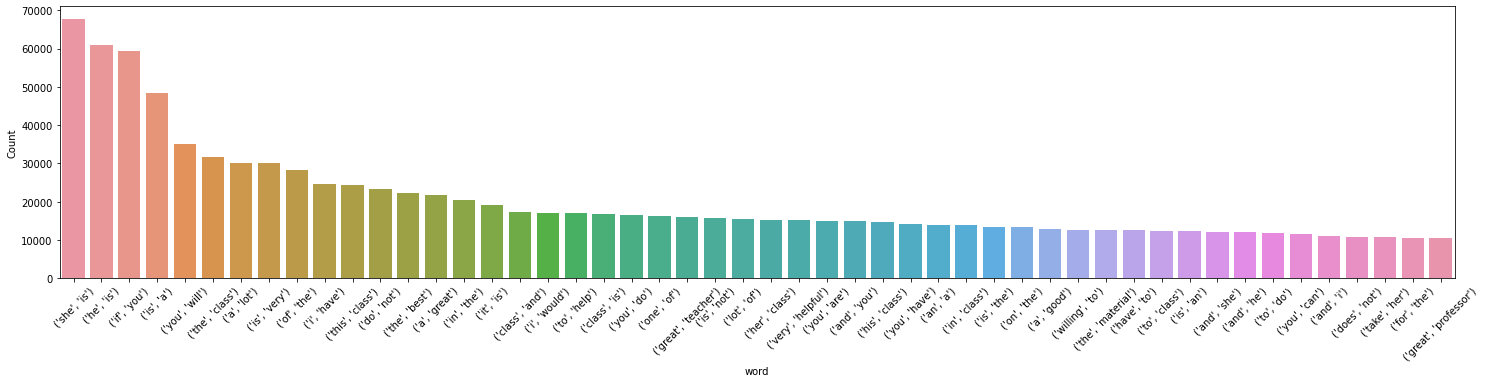

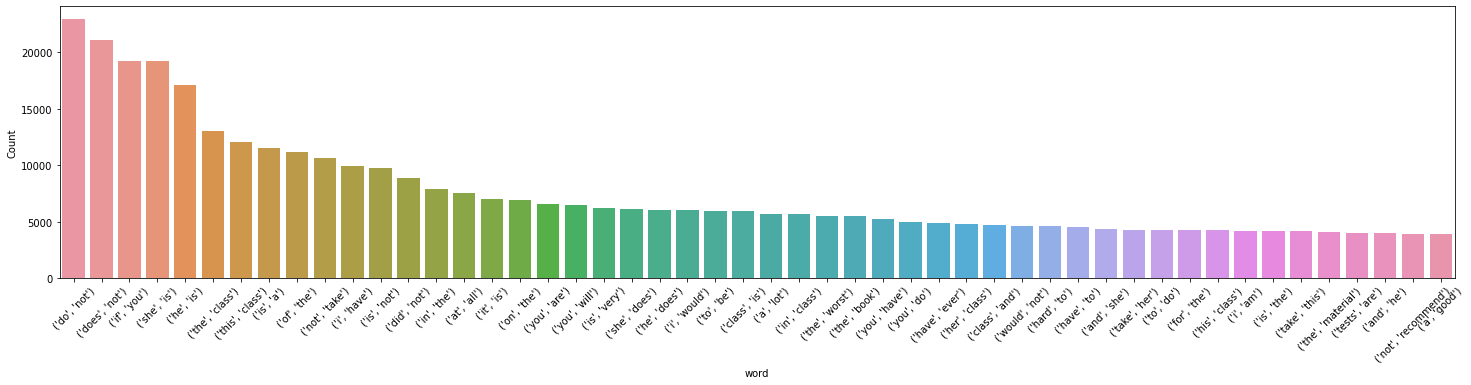

In [42]:
from nltk import FreqDist

%matplotlib inline
def freq_ngrams(x, terms=40, n=1):        # function to plot most frequent n-grams
    all_words = " ".join([text for text in x])
    all_words = all_words.split()

    ngs = nltk.ngrams(all_words, n)
    fdist = FreqDist(ngs)
    words_df = pd.DataFrame({"word":list(fdist.keys()), "count":list(fdist.values())})

    d = words_df.nlargest(columns="count", n=terms)
    plt.figure(figsize=(25,5))
    plt.xticks(rotation=45)
    ax = sns.barplot(data=d, x="word", y="count")
    ax.set(ylabel="Count")
    plt.show()

freq_ngrams(positive_reviews['cleanedComment'], terms=50, n=2)
freq_ngrams(negative_reviews['cleanedComment'], terms=50, n=2)

In [43]:
# print(cv.stop_words_)
# print(len(cv.stop_words_))

In [44]:
all_words = set()
for comment in reviews['cleanedComment']:
  unique_words_comment = set(comment.split(' '))
  all_words.update(unique_words_comment)


In [45]:
len(all_words) # 52002

56257

# Validating (or Testing???)

In [46]:
test_reviews = pd.read_csv("/content/drive/MyDrive/RMP/scraped_comments.csv").sample(n=120000, random_state=1)

In [47]:
print("Shape before dropping:", test_reviews.shape)
test_reviews.drop_duplicates(subset="comment_id", keep="first", inplace=True)

test_reviews.drop_duplicates(subset='comment', keep='first', inplace=True)

# drop rows containing only "No Comments" (default value assigned by RMP to a review that didn't enter a comment)
test_reviews = test_reviews[test_reviews["comment"] != "No Comments"]

# drop rows containing NaN comment
test_reviews.dropna(subset=["comment"], inplace=True)

# fill null names with empty string
test_reviews['firstName'].fillna('', inplace=True)
test_reviews['lastName'].fillna('', inplace=True)

# Dropping test_reviews with qualityRating == 3
test_reviews['qualityRating'] = (test_reviews['helpfulRating']+test_reviews['clarityRating'])/2.0
test_reviews = test_reviews[test_reviews["qualityRating"] != 3.0]
test_reviews["sentiment"] = test_reviews["qualityRating"] > 3.0

print("Shape after dropping:", test_reviews.shape)
test_reviews.reset_index(drop=True, inplace=True)

Shape before dropping: (120000, 16)
Shape after dropping: (105800, 18)


/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returnin

In [48]:
comments_proper = []
spellchecked_comments = []

comments_proper = preprocess_pipeline(test_reviews)

25000
50000
75000
100000


In [49]:
len(comments_proper)

105800

In [50]:
sent_predA = sent_pipeline.predict(comments_proper)

In [51]:
ones = sum(sent_pred)
zeroes = sum((i == 0 for i in sent_predA))
print(ones, zeroes, ones+zeroes)

44984 29899 74883


In [52]:
len(sent_predA)

105800

In [53]:
test_reviews.reset_index(inplace=True, drop=True)

## Classification Report

In [54]:
evalPerformance(sent_predA, test_reviews['sentiment'])
'''
Precision Score: 93.32635572708837
Recall Score: 95.03597122302159
F1 Score: 91.73347068739464
Accuracy Score: 91.73347068739464
[[26619  5101]
 [ 3726 71334]]

Precision Score: 93.76173972856425
Recall Score: 94.4337863042899
F1 Score: 91.67072485484174
Accuracy Score: 91.67072485484174
[[27004  4716]
 [ 4178 70882]]
'''

Precision Score: 93.53763455026943
Recall Score: 95.64842508016059
F1 Score: 92.3109640831758
Accuracy Score: 92.3109640831758
[[26669  4905]
 [ 3230 70996]]


'\nPrecision Score: 93.32635572708837\nRecall Score: 95.03597122302159\nF1 Score: 91.73347068739464\nAccuracy Score: 91.73347068739464\n[[26619  5101]\n [ 3726 71334]]\n\nPrecision Score: 93.76173972856425\nRecall Score: 94.4337863042899\nF1 Score: 91.67072485484174\nAccuracy Score: 91.67072485484174\n[[27004  4716]\n [ 4178 70882]]\n'

In [55]:
'''
              precision    recall  f1-score   support

       False    0.87415   0.85779   0.86589     32325
        True    0.93876   0.94638   0.94255     74455

    accuracy                        0.91956    106780
   macro avg    0.90645   0.90209   0.90422    106780
weighted avg    0.91920   0.91956   0.91935    106780


              precision    recall  f1-score   support

       False    0.84487   0.89217   0.86788     29900
        True    0.95657   0.93547   0.94590     75900

    accuracy                        0.92323    105800
   macro avg    0.90072   0.91382   0.90689    105800
weighted avg    0.92500   0.92323   0.92385    105800
'''


print(classification_report(sent_predA, test_reviews['sentiment'], digits=5))

              precision    recall  f1-score   support

       False    0.84465   0.89197   0.86767     29899
        True    0.95648   0.93538   0.94581     75901

    accuracy                        0.92311    105800
   macro avg    0.90057   0.91367   0.90674    105800
weighted avg    0.92488   0.92311   0.92373    105800



In [56]:
right = sum(a == b for a, b in zip(sent_predA, test_reviews['sentiment']))
right / len(sent_predA)

0.9231096408317581

In [85]:
sent_pipeline[0].get_feature_names_out()

array(['aa', 'aacc', 'aas', ..., 'zoomed', 'zooms', 'zooms through'],
      dtype=object)

In [77]:
sent_pipeline[:-1].get_feature_names_out()

array(['abc', 'abide', 'abide by', ..., 'zoning out', 'zooms',
       'zooms through'], dtype=object)

In [93]:
selector = sent_pipeline.named_steps['selector']
support = selector.get_support()

In [94]:
support

array([False, False, False, ..., False,  True,  True])

In [95]:
vect = sent_pipeline[0]
vect.get_feature_names_out()[support]

array(['abc', 'abide', 'abide by', ..., 'zoning out', 'zooms',
       'zooms through'], dtype=object)

In [105]:
scored_words = list(zip(selector.scores_[support], vect.get_feature_names_out()[support]))
scored_words.sort(reverse=True)

In [110]:
cnt = 0
for score, word in scored_words:
  if word.count(' ') == 1: # get trigrams
    print(f'{word}: {score}')
    cnt += 1
    if cnt == 1000:
      break

not take: 1036.6389251678268
does not: 1020.6050954213429
the worst: 851.2825961284669
worst teacher: 588.8324413040034
not recommend: 585.6486396132012
do not: 522.9251857590078
at all: 509.65159325704326
worst professor: 455.0129817395103
would not: 408.90225084571364
not helpful: 408.0485456917939
not teach: 327.52198526442356
great teacher: 318.73851471807035
not explain: 317.87643241739465
horrible teacher: 312.58826769376674
the best: 312.3036134287342
not good: 291.8570141618795
not know: 280.20581071318037
is horrible: 268.4058300896854
is great: 253.76545269961912
not very: 252.520664447965
waste of: 249.09843989278562
did not: 248.95397412439206
stay away: 247.14327362558282
not help: 246.29627866139197
all costs: 244.5512505691646
rude and: 243.29591732463393
great professor: 224.80552526154307
very helpful: 220.44354773361874
terrible teacher: 213.73273717919403
not learn: 209.81014318651097
not clear: 209.43816932408973
teach yourself: 206.47221297602675
learn anything: 19

In [117]:
model = sent_pipeline[-1]
model.coef_[0]

array([-0.12428104, -0.24062374, -0.19462594, ..., -0.14996513,
        0.12537254,  0.1475381 ])

In [130]:
import math
scored_words_lr = zip(model.coef_[0], vect.get_feature_names_out()[support])
pos, neg = [], []
for coef, word in scored_words_lr:
  pos.append((pow(math.e, coef), word))
  neg.append((pow(math.e, -coef), word))
# sorted(scored_words_lr, reverse=True)[:100]

In [131]:
sorted(pos, reverse=True)[:100]

[(132196390.25366728, 'great'),
 (102445831.47723138, 'awesome'),
 (8067236.796088491, 'amazing'),
 (1075424.730362387, 'excellent'),
 (698351.773103268, 'best'),
 (556019.8261433027, 'helpful'),
 (90639.64312241516, 'great teacher'),
 (68336.10902456148, 'very helpful'),
 (67604.73328052898, 'wonderful'),
 (32038.788594859474, 'loved'),
 (14432.077923219143, 'fun'),
 (11637.232092165586, 'fair'),
 (9202.987681032535, 'not bad'),
 (8243.272136810565, 'fantastic'),
 (6013.256469534109, 'interesting'),
 (5893.867338752057, 'great professor'),
 (5213.814246846024, 'extremely helpful'),
 (4526.012522390112, 'not the worst'),
 (4390.30292424582, 'of the best'),
 (2678.1845670435723, 'love'),
 (2306.94227996946, 'enjoyed'),
 (2042.3678245588706, 'good'),
 (1300.4149125619929, 'explains'),
 (1280.0638613471453, 'helped'),
 (1057.960464468621, 'is very helpful'),
 (1026.9213352143988, 'would take'),
 (936.4049228473402, 'easy'),
 (929.7674053815836, 'not boring'),
 (748.2528335754488, 'very cl

In [132]:
sorted(neg, reverse=True)[:100]

[(20935635.123471703, 'worst'),
 (3796296.8131283354, 'not helpful'),
 (3269726.86890404, 'horrible'),
 (2651088.9803848495, 'unclear'),
 (1312832.0303680087, 'not'),
 (706396.0872519668, 'avoid'),
 (240964.8665335098, 'confusing'),
 (190831.37368695685, 'terrible'),
 (144176.26248957598, 'useless'),
 (141703.4962326963, 'disorganized'),
 (111653.81708936294, 'not very helpful'),
 (92726.7156379685, 'rude'),
 (91886.25983266509, 'not very'),
 (28239.122134099507, 'not recommend'),
 (22016.435926681297, 'not good'),
 (15767.218294693803, 'awful'),
 (15444.900402469908, 'not the best'),
 (15146.001674647756, 'not great'),
 (13696.602126119773, 'not very clear'),
 (12248.503720818504, 'not clear'),
 (10451.318007900894, 'vague'),
 (9720.725028310637, 'unhelpful'),
 (7216.509788081206, 'nothing'),
 (5092.44297650332, 'incomprehensible'),
 (4765.292111568122, 'confused'),
 (4147.095143945519, 'hard to understand'),
 (3699.8586903751648, 'unorganized'),
 (3166.940812237708, 'not good teacher

# Possible Improvements
* Could engineer new features using words that are capitalized in the review
* Remove reviews that're not english